# Exploratory data analysis of IMD Best Track data (pre-processed)

In [43]:
import pandas as pd
import xarray as xr
import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [44]:
bt = pd.read_csv('CYCLONE_BEST_TRACK_AS_AND_BOB_FROM_IMD.csv', index_col = 0)
bt.index = pd.to_datetime(bt.index)
#bt = bt[(bt.index.year == 2019)]

In [45]:
bt['Basin of origin'].value_counts()

Basin of origin
BOB     4437
ARB     1157
AS       832
LAND     241
Land       8
land       3
Name: count, dtype: int64

In [46]:
bt = bt[(bt['Basin of origin'] == 'ARB') | (bt['Basin of origin'] == 'AS') | (bt['Basin of origin'] == 'BOB')]

In [47]:
bt_cropped = bt[['Serial Number of system during year', 'Latitude (lat.)', 'Longitude (lon.)', 'Maximum Sustained Surface Wind (kt) ', 'Grade (text)']]

## Different types of systems for which preprocessed BT data is made available by IMD

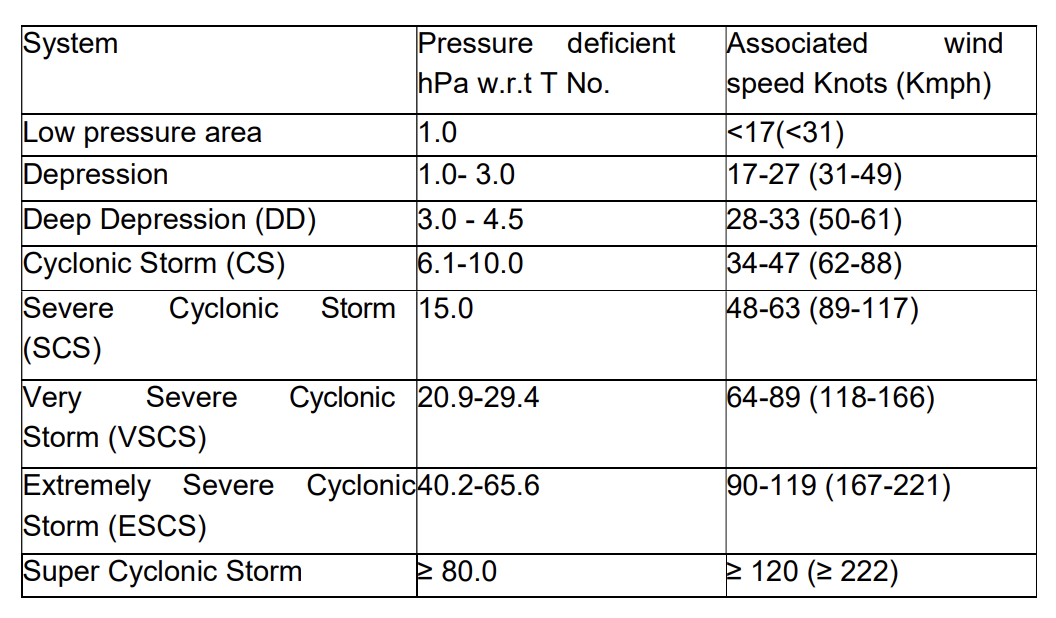


Best track records for both Depression, Deep Depression and Low Pressure Area are removed from the data for this analysis.

In [48]:
# Count of data entries based on cyclone category
bt_cropped['Grade (text)'].value_counts()

Grade (text)
D                2130
CS               1431
DD               1364
SCS               571
VSCS              551
ESCS              313
SuCS               25
SUCS               15
      D             4
D Over   land       3
DD                  1
Cs                  1
Name: count, dtype: int64

In [49]:
# Note that SuCS and SUCS mean the same i.e., Super Cyclonic Storm. I'm rewriting Grade for this category as shown below to avoid errors while doing case sensitive operations.
bt_cropped.loc[:,'Grade (text)'] = bt_cropped['Grade (text)'].replace(to_replace='SuCS', value='SUCS')
bt_cropped.loc[:,'Grade (text)'] = bt_cropped['Grade (text)'].replace(to_replace='      D', value='D')
bt_cropped.loc[:,'Grade (text)'] = bt_cropped['Grade (text)'].replace(to_replace='D Over   land', value='D')
bt_cropped.loc[:,'Grade (text)'] = bt_cropped['Grade (text)'].replace(to_replace='DD ', value='DD')
bt_cropped.loc[:,'Grade (text)'] = bt_cropped['Grade (text)'].replace(to_replace='Cs', value='CS')

In [50]:
bt_cropped['Grade (text)'].value_counts()

Grade (text)
D       2137
CS      1432
DD      1365
SCS      571
VSCS     551
ESCS     313
SUCS      40
Name: count, dtype: int64

In [51]:
bt_cropped = bt_cropped[bt_cropped['Grade (text)'].isna() == False]

## Centering TC data about its Lifetime Maximum Intensity point (while cropping out any D or DD that don't develop into a CS)

In [52]:
tcs_lmi_centred = []
count = 0
for tc_id, tc_data in bt_cropped.groupby(bt_cropped['Serial Number of system during year']):
    # The below if-statement is to check if any D or DD develops into a CS during it's lifetime.
    if any('CS' in item for item in set(bt_cropped[bt_cropped['Serial Number of system during year'] == tc_id]['Grade (text)'].values)) == True:
        lmi_index = tc_data['Maximum Sustained Surface Wind (kt) '].idxmax()
        tc_data['TimeRelativeToLMI'] = (tc_data.index - lmi_index).total_seconds() / (3600 * 24)
        tcs_lmi_centred += [tc_data]
    else:
        count += 1

print('{} systems out of {} didn\'t mature into a CS'.format(count, len(list(bt_cropped['Serial Number of system during year'].unique()))))
tcs_lmi_centred = pd.concat(tcs_lmi_centred)

#tcs_lmi_centred = tcs_lmi_centred[['Maximum Sustained Surface Wind (kt) ', 'TimeRelativeToLMI', 'Serial Number of system during year']]

186 systems out of 349 didn't mature into a CS


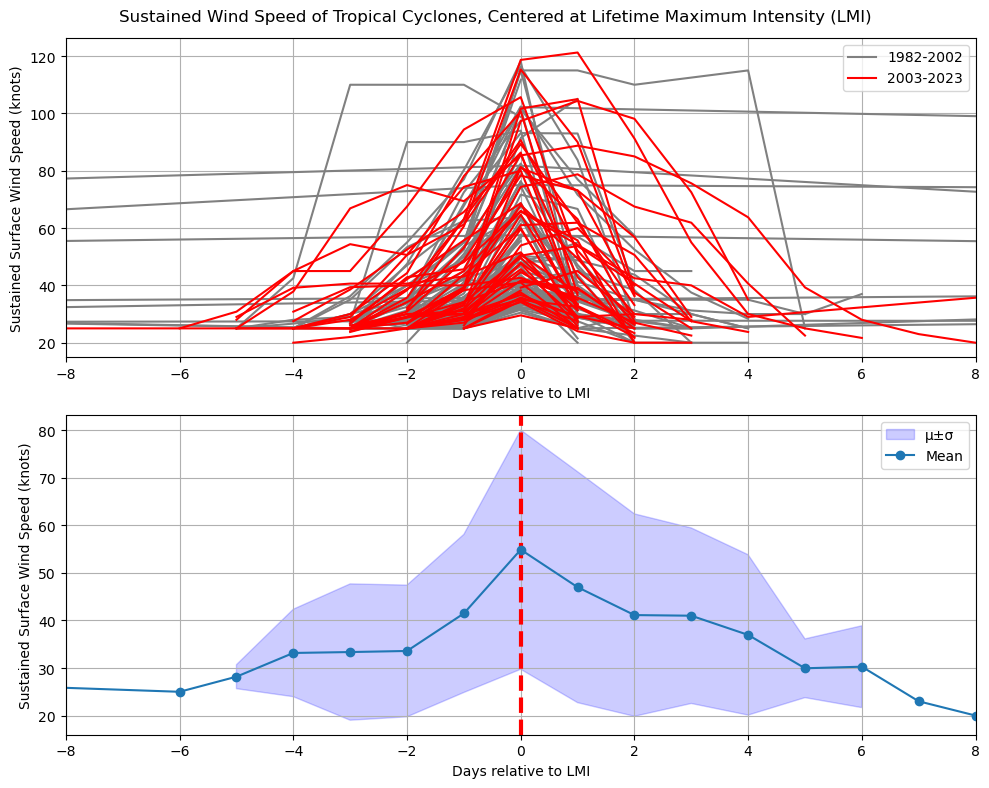

In [53]:
fig, axes = plt.subplots(2,1, figsize = (10,8))
fig.suptitle('Sustained Wind Speed of Tropical Cyclones, Centered at Lifetime Maximum Intensity (LMI)')

axes = axes.flatten()
for tc_id, tc_data in tcs_lmi_centred.groupby('Serial Number of system during year'):
    tc_data = tc_data[['Maximum Sustained Surface Wind (kt) ', 'TimeRelativeToLMI', 'Serial Number of system during year']]
    tc_data.set_index('TimeRelativeToLMI', inplace = True)
    tc_data = tc_data.groupby(tc_data.index.astype(int)).mean()
    if ((tc_id//100) >= 1982) & ((tc_id//100) <= 2012):
        axes[0].plot(tc_data.index, tc_data['Maximum Sustained Surface Wind (kt) '], label = '1982-2002', color = 'gray')
    else:
        axes[0].plot(tc_data.index, tc_data['Maximum Sustained Surface Wind (kt) '], label = '2003-2023', color = 'red')

handles, labels = axes[0].get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
axes[0].legend(unique_labels.values(), unique_labels.keys())

axes[0].set_xlim([-8,8])
axes[0].set_xlabel('Days relative to LMI')
axes[0].set_ylabel('Sustained Surface Wind Speed (knots)')
axes[0].grid(True)

mean = tcs_lmi_centred.drop('Grade (text)', axis = 1).groupby('TimeRelativeToLMI').mean()['Maximum Sustained Surface Wind (kt) ']
std = tcs_lmi_centred.drop('Grade (text)', axis = 1).groupby('TimeRelativeToLMI').std()['Maximum Sustained Surface Wind (kt) ']

mean = mean.groupby(mean.index.astype(int)).mean()
std = std.groupby(std.index.astype(int)).mean()

axes[1].axvline(0, color = 'red', ls = '--', lw = 3)
axes[1].fill_between(std.index, (mean-std), (mean+std), alpha = 0.2, color = 'blue', label = 'µ±σ')
axes[1].plot(mean.index, mean, marker = 'o', label = 'Mean')
axes[1].legend()
axes[1].set_xlim([-8,8])
axes[1].set_xlabel('Days relative to LMI')
axes[1].set_ylabel('Sustained Surface Wind Speed (knots)')
axes[1].grid(True)
fig.tight_layout()

---

## Classifying MHW and non-MHW TCs based on the study being referred to 

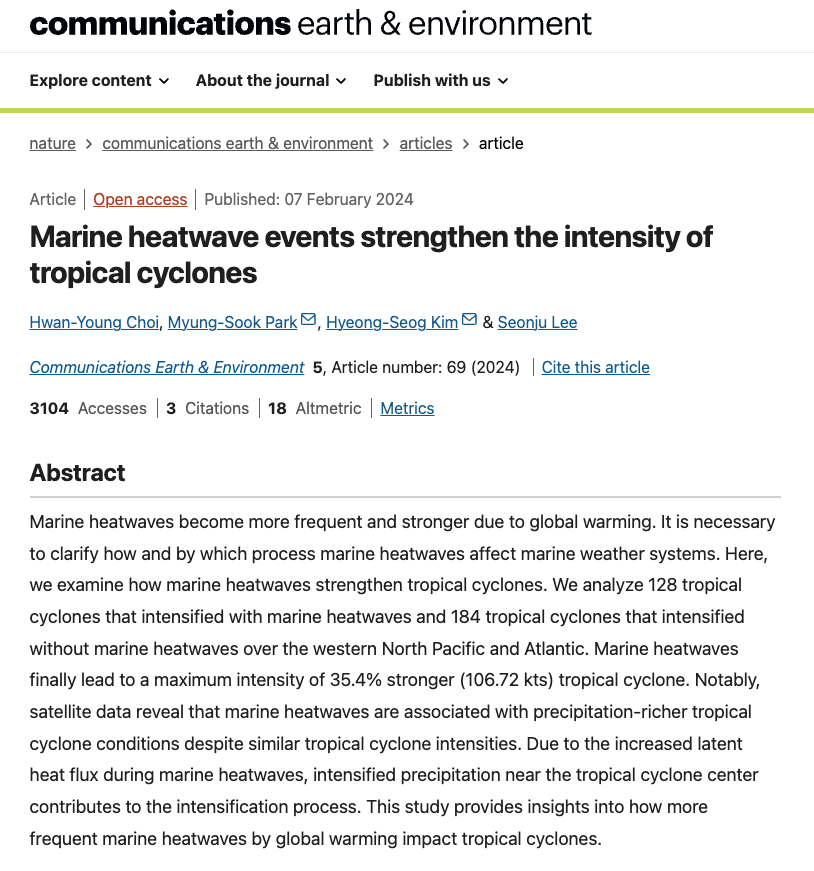

### Method:<br>
"To examine the impact of an MHW on a TC in the intensification phase, we defined an MHW TC as a TC whose center stayed within 1 degree of an MHW area for two days or more before reaching the LMI. <br>
TCs that never encountered MHWs in their lifetime were defined as non-MHW TCs. This spatial threshold (1 degree of an MHW area) can cover the TC core area, so it can directly impact TC and the <br>
time threshold (more than 2 days) is enough time for impact on the TCs. Additionally, TCs that encountered an MHW region <24 hours before reaching the LMI or TCs that passed an MHW region <br>
after the LMI were excluded from this study."

### Citation: <br>
Choi, HY., Park, MS., Kim, HS. et al. Marine heatwave events strengthen the intensity of tropical cyclones. Commun Earth Environ 5, 69 (2024). https://doi.org/10.1038/s43247-024-01239-4

First sort out the parameters:

In [73]:
proximity_thres_to_mhw = 0.25 # How close-by the TC has to go to an MHW to be classed as one that's potentially influenced by that MHW?
d = 1 # How many days worth of data (atleast) before reaching LMI point is required? 
#'d' is also used to check if the TC BT stays within proximity_thres_to_mhw degrees of an MHW area for these many days, before classifying it into a MHW TC or not.

In [74]:
# Loading in the MHW mask (Courtesy: https://github.com/ligin1/Marine-Heat-Waves by Ligin Joseph from Uni of Soton and NOCS UK)
ds = xr.open_dataset('./mhw_1982_2023.nc').rename({'__xarray_dataarray_variable__':'mhw_mask'})
ds['time'] = pd.to_datetime([str(x).split('T')[0] for x in ds.time.values])

## Selecting only the cyclones which had atleast 'd' days worth of data before reaching LMI point

In [75]:
df = pd.DataFrame(columns = ['TC_ID', 'HOURS_BEFORE_LMI_GREATER_THAN_D_DAYS'])
for tc_id, tc_data in tcs_lmi_centred.groupby(tcs_lmi_centred['Serial Number of system during year']):
    tvals = tc_data[tc_data.TimeRelativeToLMI <= 0].index
    if (tvals[-1] - tvals[0]).total_seconds()/3600 >= 24*d: 
        # Difference between when first and last entry (LMI) is recorded should be >= 24*d hrs
        tdelta = 1
    else:
        tdelta = 0
    df.loc[len(df)] = [tc_id, tdelta]

tcs_lmi_centred_selected = tcs_lmi_centred[tcs_lmi_centred['Serial Number of system during year'].isin(df[df['HOURS_BEFORE_LMI_GREATER_THAN_D_DAYS'] == 1]['TC_ID'].values)]

/var/folders/3t/w3vt3f7s745cdpdml8l8wtl00000gp/T/ipykernel_7394/3099750372.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='tab10')


Text(0, 0.5, 'Number of TCs')

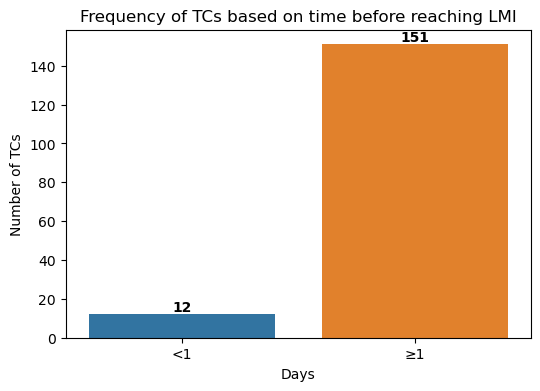

In [76]:
counts = df['HOURS_BEFORE_LMI_GREATER_THAN_D_DAYS'].value_counts().sort_index()

# Map the values to 'NO' and 'YES'
labels = {0: '<{}'.format(d), 1: '≥{}'.format(d)}
counts.index = counts.index.map(labels)
plt.figure(figsize=(6, 4))
sns.barplot(x=counts.index, y=counts.values, palette='tab10')

# Annotate the bars with the count
for i, value in enumerate(counts.values):
    plt.text(i, value + 0.1, f'{value}', ha='center', va='bottom', fontweight='bold')

plt.title('Frequency of TCs based on time before reaching LMI')
plt.xlabel('Days')
plt.ylabel('Number of TCs')

## Checking the percentage of points that pass over an MHW (using 'nearest' gricell method to determine)

In [77]:
df = pd.DataFrame(columns = ['TC_ID', 'PERCENT_POINTS_OVER_MHW'])
for tc_id, tc_data in tcs_lmi_centred_selected.groupby(tcs_lmi_centred_selected['Serial Number of system during year']):
    mhw_mask_vals = []
    for x in tc_data.iterrows():
        mhw_mask_vals = mhw_mask_vals + [ds.sel(lat = x[1]['Latitude (lat.)'], lon = x[1]['Longitude (lon.)'], time = x[0], method = 'nearest')['mhw_mask'].item()]

    mhw_mask_vals = np.array(mhw_mask_vals)
    mhw_mask_vals[np.isnan(mhw_mask_vals)] = 0
    threshold = (mhw_mask_vals.sum()*100)/mhw_mask_vals.shape[0]
    df.loc[len(df)] = [tc_id, np.round(threshold,2)]

Text(0, 0.5, 'Frequency')

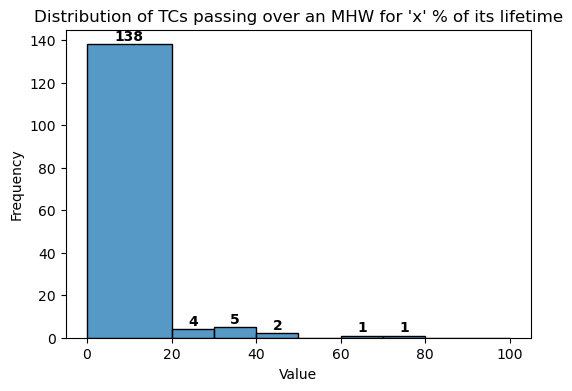

In [78]:
plt.figure(figsize=(6, 4))
histplot = sns.histplot(df['PERCENT_POINTS_OVER_MHW'], bins = [0,20,30,40,50,60,70,80,90,100], kde=False)  # Adjust bins as needed

# Annotate bars with the count
for patch in histplot.patches:
    # Get the height of each bar (which corresponds to the count)
    height = patch.get_height()
    # Only annotate if the height is greater than 0
    if height > 0:
        # Get the x-position of the center of the bar
        plt.text(patch.get_x() + patch.get_width() / 2, height + 0.5,  # Adjust the position if needed
                 f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')


plt.xticks(np.arange(0, 101, 20))

plt.title("Distribution of TCs passing over an MHW for 'x' % of its lifetime")
plt.xlabel('Value')
plt.ylabel('Frequency')

In [79]:
# Function to calculate the distance in degrees
def distance_in_degrees(lat1, lon1, lat2, lon2):
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    # Adjust for the varying distance of longitude with latitude
    distance = np.sqrt(delta_lat**2 + (delta_lon * np.cos(np.radians(lat1)))**2)
    return distance

def check_if_point_close_to_mhw(x, thres = 1):
    mask = ds.sel(time = '{}-{:02d}-{}'.format(x[0].year, x[0].month, x[0].day))['mhw_mask'].values 

    # Given point (lat, lon)
    point_lon, point_lat = x[1]['Longitude (lon.)'], x[1]['Latitude (lat.)']

    # Loop through all grid points and check if within 1-degree radius
    found_1_within_radius = False
    for lat_idx, lat in enumerate(ds['lat'].values):
        for lon_idx, lon in enumerate(ds['lon'].values):
            distance = distance_in_degrees(point_lat, point_lon, lat, lon)
            if distance <= thres:  # Check within {thres}-degree radius
                if mask[lat_idx, lon_idx] == 1:
                    found_1_within_radius = True
                    break
        if found_1_within_radius:
            break

    if found_1_within_radius:
        return 1
    else:
        return 0 

## Classifying TCs based on Choi et al., 2024

In [80]:
df = pd.DataFrame(columns = ['TC_ID', 'CLASS'])
for tc_id, tc_data in tcs_lmi_centred_selected[tcs_lmi_centred_selected.index.year<2023].groupby(tcs_lmi_centred_selected[tcs_lmi_centred_selected.index.year<2023]['Serial Number of system during year']):
    mhw_flag = []
    for x in tc_data.iterrows():
        mhw_flag = mhw_flag + [check_if_point_close_to_mhw(x, thres = proximity_thres_to_mhw)]
    tc_data['MHW_FLAG'] = mhw_flag
    if tc_data[tc_data.TimeRelativeToLMI < 0]['MHW_FLAG'].sum() >= 8*d:
        # Condition for MHW TC: Atleast the last 'd' days' entries (1 day = 8 entries)
        # before LMI point is reached are close to any MHW-identified gridcells
        df.loc[len(df)] = [tc_id, 'MHW']
    elif tc_data['MHW_FLAG'].sum() == 0:
        # Condition for NON-MHW TC: At no point is a TC's best track is 
        # close to a MHW-identified gridcell
        df.loc[len(df)] = [tc_id, 'NON-MHW']
    else:
        # Other TCs that come close to an MHW atleast once, but are not 
        # thoroughly (atleast by the definition we chose) impacted by 
        # the MHW (like MHW TCs).
        df.loc[len(df)] = [tc_id, 'OTHER']

([<matplotlib.patches.Wedge at 0x319dca150>,
 [Text(-0.9969385560680448, 0.4648801086570192, 'NON-MHW'),
  Text(0.9010672273862225, -0.6309341104509297, 'OTHER'),
  Text(1.0832885235940588, -0.19101302219849944, 'MHW')],
 [Text(-0.5437846669462062, 0.25357096835837406, '86.1%\n(124)'),
  Text(0.49149121493793946, -0.3441458784277798, '8.3%\n(12)'),
  Text(0.5908846492331229, -0.10418892119918151, '5.6%\n(8)')])

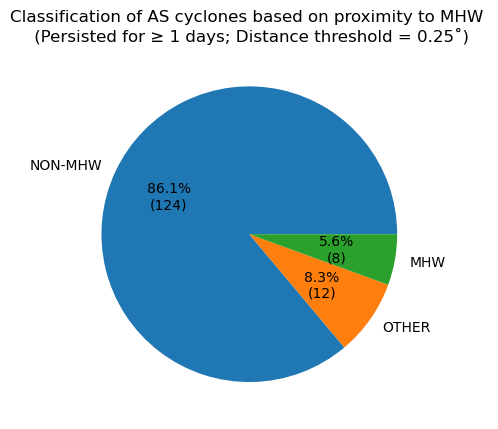

In [81]:
# Pie-chart distribution of MHW, NON-MHW and OTHER (i.e. partly influenced) TCs
# https://stackoverflow.com/a/71515035/2901002
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

s = df['CLASS'].value_counts()
plt.title('Classification of AS cyclones based on proximity to MHW \n (Persisted for ≥ {} days; Distance threshold = {}˚)'.format(d, proximity_thres_to_mhw))
plt.pie(s,labels = s.index, autopct=autopct_format(s))

In [82]:
# Indexing tcs_lmi_centred_selected dataframes based on CLASS of influence, concatenating and saving it as a dictionary

tcs_classified = {'MHW':[], 'NON-MHW':[], 'OTHER':[]}

for idx in df['TC_ID'][df['CLASS'] == 'MHW'].values:
    tcs_lmi_centred_selected[tcs_lmi_centred_selected['Serial Number of system during year'] == idx]
    tcs_classified['MHW'] += [tcs_lmi_centred_selected[tcs_lmi_centred_selected['Serial Number of system during year'] == idx]]

for idx in df['TC_ID'][df['CLASS'] == 'NON-MHW'].values:
    tcs_lmi_centred_selected[tcs_lmi_centred_selected['Serial Number of system during year'] == idx]
    tcs_classified['NON-MHW'] += [tcs_lmi_centred_selected[tcs_lmi_centred_selected['Serial Number of system during year'] == idx]]

for idx in df['TC_ID'][df['CLASS'] == 'OTHER'].values:
    tcs_lmi_centred_selected[tcs_lmi_centred_selected['Serial Number of system during year'] == idx]
    tcs_classified['OTHER'] += [tcs_lmi_centred_selected[tcs_lmi_centred_selected['Serial Number of system during year'] == idx]]


tcs_classified['MHW'] = pd.concat(tcs_classified['MHW'])
tcs_classified['NON-MHW'] = pd.concat(tcs_classified['NON-MHW'])
tcs_classified['OTHER'] = pd.concat(tcs_classified['OTHER'])

In [83]:

def ensemble_plotter(tc_data = None, ax = None, c = None, tc_type = None):
    mean = tc_data.drop('Grade (text)', axis = 1).groupby('TimeRelativeToLMI').mean()['Maximum Sustained Surface Wind (kt) ']
    std = tc_data.drop('Grade (text)', axis = 1).groupby('TimeRelativeToLMI').std()['Maximum Sustained Surface Wind (kt) ']

    # mean = mean.groupby(mean.index.astype(int)).mean()
    # std = std.groupby(std.index.astype(int)).mean()
    
    ax.fill_between(std.index, (mean-std), (mean+std), alpha = 0.2, color = c, label = tc_type+': µ±σ')
    ax.plot(mean.index, mean, marker = 'o', label = tc_type+': Mean', color = c)

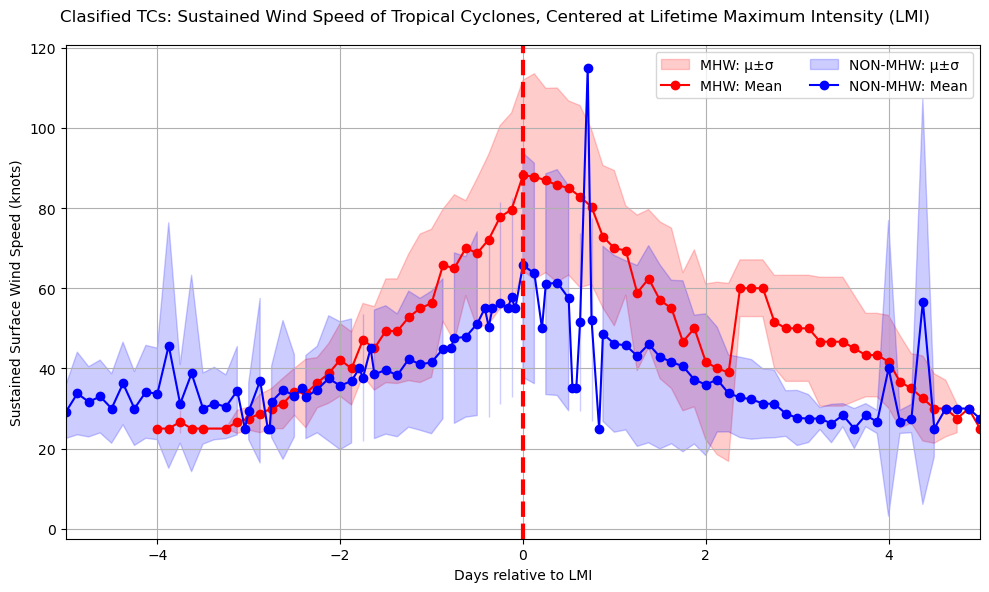

In [84]:
fig, ax = plt.subplots(1,1, figsize = (10,6))
fig.suptitle('Clasified TCs: Sustained Wind Speed of Tropical Cyclones, Centered at Lifetime Maximum Intensity (LMI)')
ensemble_plotter(tcs_classified['MHW'], ax, 'red', tc_type = 'MHW')
ensemble_plotter(tcs_classified['NON-MHW'], ax, 'blue', tc_type = 'NON-MHW')
#ensemble_plotter(tcs_classified['OTHER'], ax, 'green', tc_type = 'NON-MHW')
ax.axvline(0, color = 'red', ls = '--', lw = 3)
ax.legend(ncols = 2)
ax.set_xlim([-5,5])
ax.set_xlabel('Days relative to LMI')
ax.set_ylabel('Sustained Surface Wind Speed (knots)')
ax.grid(True)
fig.tight_layout()